# NBA Halftime Prediction Model

Can we predict whether the home team wins using only first-half data?

**Features:**
- Halftime scores and score differential
- Q1 scores and score differential
- Scoring momentum (Q2 vs Q1 scoring change)
- FG% by shot zone (paint, midrange, three) for each team
- Shot distribution by zone for each team

**Models:** Logistic Regression, Random Forest

**Data:** ~913,000 play-by-play rows across 1,830 NBA games (2024-25 + partial 2025-26)

## 1. Load Data

In [1]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

conn = psycopg2.connect(
    dbname=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    host=os.getenv('DB_HOST'),
    password=os.getenv('DB_PASSWORD'),
    port=os.getenv('DB_PORT')
)

df = pd.read_sql('SELECT * FROM nba_data', conn)
conn.close()

print(f'Rows: {len(df):,}')
df.head()

/var/folders/dd/6kl1jzkj5tlgq3c91gqmbz940000gn/T/ipykernel_21244/319017163.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM nba_data', conn)


Rows: 913,461


,gameid,clock,period,teamid,personid,playername,xlegacy,ylegacy,shotdistance,shotresult,isfieldgoal,scorehome,scoreaway,pointstotal,location,description,actiontype,shotvalue,actionid
0,0022400541,01:43.00,3,1610612758,1631099,Murray,-7.0,4.0,1.0,Made,1,91,89,180,v,Murray 1' Running Dunk (11 PTS) (Fox 2 AST),Made Shot,2,341
1,0022400541,01:28.00,3,1610612741,1641763,Phillips,-6.0,13.0,1.0,Made,1,93,89,182,h,Phillips 1' Cutting Dunk Shot (2 PTS) (William...,Made Shot,2,342
2,0022400541,01:15.00,3,1610612758,201942,DeRozan,7.0,177.0,18.0,Missed,1,93,89,0,v,MISS DeRozan 18' Pullup Jump Shot,Missed Shot,2,343
3,0022400541,01:11.00,3,1610612758,1626168,Lyles,0.0,0.0,0.0,None,0,93,89,0,v,Lyles REBOUND (Off:1 Def:6),Rebound,0,344
4,0022400541,01:01.00,3,1610612758,1631099,Murray,-136.0,30.0,14.0,Missed,1,93,89,0,v,MISS Murray 14' Step Back Jump Shot,Missed Shot,2,345


## 2. Target Variable

Determine the winner of each game from the final scores (last row per game).

In [2]:
final_scores = df.groupby('gameid')[['scorehome', 'scoreaway']].last()
final_scores['home_win'] = (final_scores['scorehome'] > final_scores['scoreaway']).astype(int)

print(f"Games: {len(final_scores)}")
print(final_scores['home_win'].value_counts())
final_scores.head(10)

Games: 1830
home_win
1    1008
0     822
Name: count, dtype: int64


,scorehome,scoreaway,home_win
gameid,,,
0022400001,0,0,0
0022400002,123,121,1
0022400003,114,89,1
0022400004,99,111,0
0022400005,99,85,1
0022400006,112,120,0
0022400007,120,117,1
0022400008,122,108,1
0022400009,111,124,0


## 3. Feature Engineering

### 3a. Halftime Scores and Differential

In [3]:
first_half = df[df['period'] <= 2]

lead = first_half.groupby('gameid')[['scorehome', 'scoreaway']].last()
lead['halftime_diff'] = lead['scorehome'] - lead['scoreaway']
lead.head(10)

,scorehome,scoreaway,halftime_diff
gameid,,,
0022400001,0,0,0
0022400002,57,51,6
0022400003,58,47,11
0022400004,50,54,-4
0022400005,54,43,11
0022400006,49,64,-15
0022400007,59,63,-4
0022400008,60,53,7
0022400009,55,61,-6


### 3b. Q1 Scores and Differential

In [4]:
first_quarter = df[df['period'] <= 1].groupby('gameid')[['scorehome', 'scoreaway']].last()
first_quarter['Q1Difference'] = first_quarter['scorehome'] - first_quarter['scoreaway']

features = lead.join(first_quarter, lsuffix='_half', rsuffix='_q1')
features.head(10)

,scorehome_half,scoreaway_half,halftime_diff,scorehome_q1,scoreaway_q1,Q1Difference
gameid,,,,,,
0022400001,0,0,0,0,0,0
0022400002,57,51,6,32,21,11
0022400003,58,47,11,31,29,2
0022400004,50,54,-4,25,27,-2
0022400005,54,43,11,26,21,5
0022400006,49,64,-15,21,33,-12
0022400007,59,63,-4,33,27,6
0022400008,60,53,7,28,17,11
0022400009,55,61,-6,29,26,3


### 3c. Scoring Momentum

Momentum = Q2 scoring - Q1 scoring. Positive means the team scored more in Q2 than Q1.

In [5]:
home_momentum = (features['scorehome_half'] - features['scorehome_q1']) - features['scorehome_q1']
away_momentum = (features['scoreaway_half'] - features['scoreaway_q1']) - features['scoreaway_q1']

features['home_momentum'] = home_momentum
features['away_momentum'] = away_momentum
features.head(10)

,scorehome_half,scoreaway_half,halftime_diff,scorehome_q1,scoreaway_q1,Q1Difference,home_momentum,away_momentum
gameid,,,,,,,,
0022400001,0,0,0,0,0,0,0,0
0022400002,57,51,6,32,21,11,-7,9
0022400003,58,47,11,31,29,2,-4,-11
0022400004,50,54,-4,25,27,-2,0,0
0022400005,54,43,11,26,21,5,2,1
0022400006,49,64,-15,21,33,-12,7,-2
0022400007,59,63,-4,33,27,6,-7,9
0022400008,60,53,7,28,17,11,4,19
0022400009,55,61,-6,29,26,3,-3,9


### 3d. Shot Zones

Classify first-half shots into three zones based on distance:
- **Paint**: 0-8 ft
- **Midrange**: 8-23.75 ft
- **Three**: 23.75+ ft

In [6]:
first_half_shots = first_half[first_half['isfieldgoal'] == 1].copy()
first_half_shots['zone'] = pd.cut(
    first_half_shots['shotdistance'],
    bins=[0, 8, 23.75, 100],
    labels=['paint', 'midrange', 'three']
)
first_half_shots['made'] = (first_half_shots['shotresult'] == 'Made').astype(int)

print(f"First-half shot attempts: {len(first_half_shots):,}")
first_half_shots[['gameid', 'shotdistance', 'zone', 'shotresult']].head(10)

First-half shot attempts: 166,371


,gameid,shotdistance,zone,shotresult
139,0022400542,27.0,three,Missed
143,0022400542,25.0,three,Made
150,0022400542,12.0,midrange,Missed
154,0022400542,0.0,NaN,Missed
156,0022400542,27.0,three,Missed
158,0022400542,27.0,three,Missed
160,0022400542,3.0,paint,Made
161,0022400542,26.0,three,Missed
163,0022400542,27.0,three,Missed
165,0022400542,27.0,three,Made


### 3e. FG% by Zone

In [7]:
fg_pct = first_half_shots.groupby(['gameid', 'location', 'zone'], observed=True)['made'].mean()
fg_pct_flat = fg_pct.unstack(['location', 'zone'])
fg_pct_flat.columns = [
    f"{'home' if loc == 'h' else 'away'}_fg_{zone}"
    for loc, zone in fg_pct_flat.columns
]
fg_pct_flat.head()

,home_fg_paint,home_fg_midrange,home_fg_three,away_fg_paint,away_fg_midrange,away_fg_three
gameid,,,,,,
0022400001,0.818182,0.500000,0.391304,0.650000,0.428571,0.263158
0022400002,0.578947,0.500000,0.066667,0.478261,0.000000,0.368421
0022400003,0.692308,0.769231,0.214286,0.533333,0.222222,0.500000
0022400004,0.428571,0.428571,0.312500,0.500000,0.636364,0.333333
0022400005,0.571429,0.285714,0.280000,0.375000,0.428571,0.200000


### 3f. Shot Distribution by Zone

In [8]:
shot_dist = first_half_shots.groupby(['gameid', 'location'], observed=True)['zone'].value_counts(normalize=True)
shot_dist_flat = shot_dist.unstack(['location', 'zone'])
shot_dist_flat.columns = [
    f"{'home' if loc == 'h' else 'away'}_dist_{zone}"
    for loc, zone in shot_dist_flat.columns
]
shot_dist_flat.head()

,home_dist_three,home_dist_paint,home_dist_midrange,away_dist_paint,away_dist_three,away_dist_midrange
gameid,,,,,,
0022400001,0.575000,0.275000,0.150000,0.434783,0.413043,0.152174
0022400002,0.375000,0.475000,0.150000,0.511111,0.422222,0.066667
0022400003,0.350000,0.325000,0.325000,0.394737,0.368421,0.236842
0022400004,0.432432,0.378378,0.189189,0.409091,0.340909,0.250000
0022400005,0.543478,0.304348,0.152174,0.666667,0.138889,0.194444


### Join All Features

In [9]:
final_df = features.join(fg_pct_flat).join(shot_dist_flat).join(final_scores['home_win'])
final_df = final_df.fillna(0)

print(f"Games: {len(final_df)}, Features: {len(final_df.columns) - 1}")
final_df.head()

Games: 1830, Features: 20


,scorehome_half,scoreaway_half,halftime_diff,scorehome_q1,scoreaway_q1,Q1Difference,home_momentum,away_momentum,home_fg_paint,home_fg_midrange,...,away_fg_paint,away_fg_midrange,away_fg_three,home_dist_three,home_dist_paint,home_dist_midrange,away_dist_paint,away_dist_three,away_dist_midrange,home_win
gameid,,,,,,,,,,,,,,,,,,,,,
0022400001,0,0,0,0,0,0,0,0,0.818182,0.500000,...,0.650000,0.428571,0.263158,0.575000,0.275000,0.150000,0.434783,0.413043,0.152174,0
0022400002,57,51,6,32,21,11,-7,9,0.578947,0.500000,...,0.478261,0.000000,0.368421,0.375000,0.475000,0.150000,0.511111,0.422222,0.066667,1
0022400003,58,47,11,31,29,2,-4,-11,0.692308,0.769231,...,0.533333,0.222222,0.500000,0.350000,0.325000,0.325000,0.394737,0.368421,0.236842,1
0022400004,50,54,-4,25,27,-2,0,0,0.428571,0.428571,...,0.500000,0.636364,0.333333,0.432432,0.378378,0.189189,0.409091,0.340909,0.250000,0
0022400005,54,43,11,26,21,5,2,1,0.571429,0.285714,...,0.375000,0.428571,0.200000,0.543478,0.304348,0.152174,0.666667,0.138889,0.194444,1


## 4. Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split

X = final_df.drop('home_win', axis=1)
y = final_df['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 1464, Test: 366


## 5. Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print(f"Train accuracy: {lr_model.score(X_train_scaled, y_train):.3f}")
print(f"Test accuracy: {lr_model.score(X_test_scaled, y_test):.3f}")

Train accuracy: 0.732
Test accuracy: 0.730


/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:

## 6. Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

print(f"Train accuracy: {rf_model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {rf_model.score(X_test, y_test):.3f}")

Train accuracy: 0.785
Test accuracy: 0.710


## 7. Results

### Confusion Matrix

/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/condailey/projects/nba-data-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


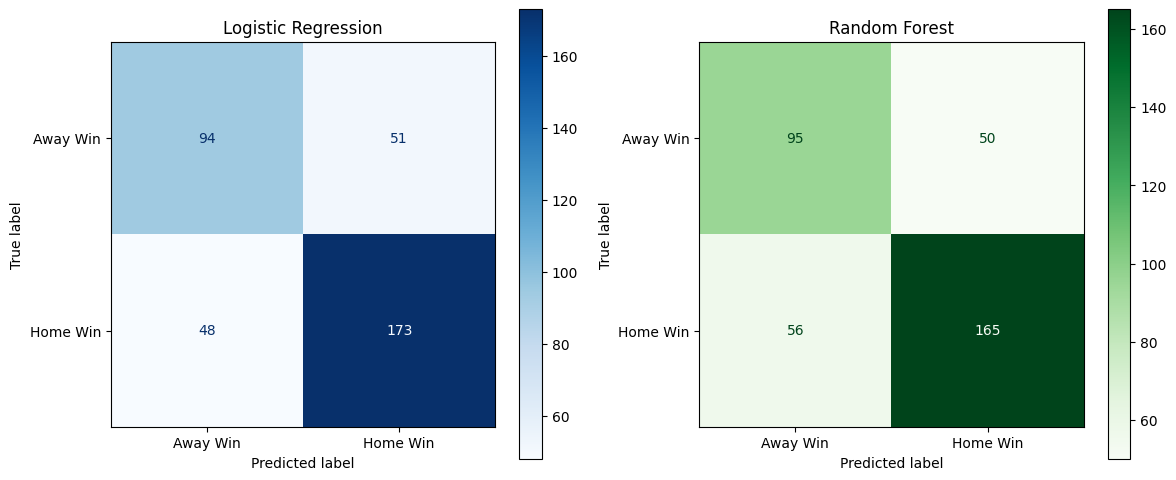

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, lr_model.predict(X_test_scaled))
ConfusionMatrixDisplay(cm_lr, display_labels=['Away Win', 'Home Win']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')

# Random Forest
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
ConfusionMatrixDisplay(cm_rf, display_labels=['Away Win', 'Home Win']).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Random Forest')

plt.tight_layout()
plt.show()

### Feature Importance (Random Forest)

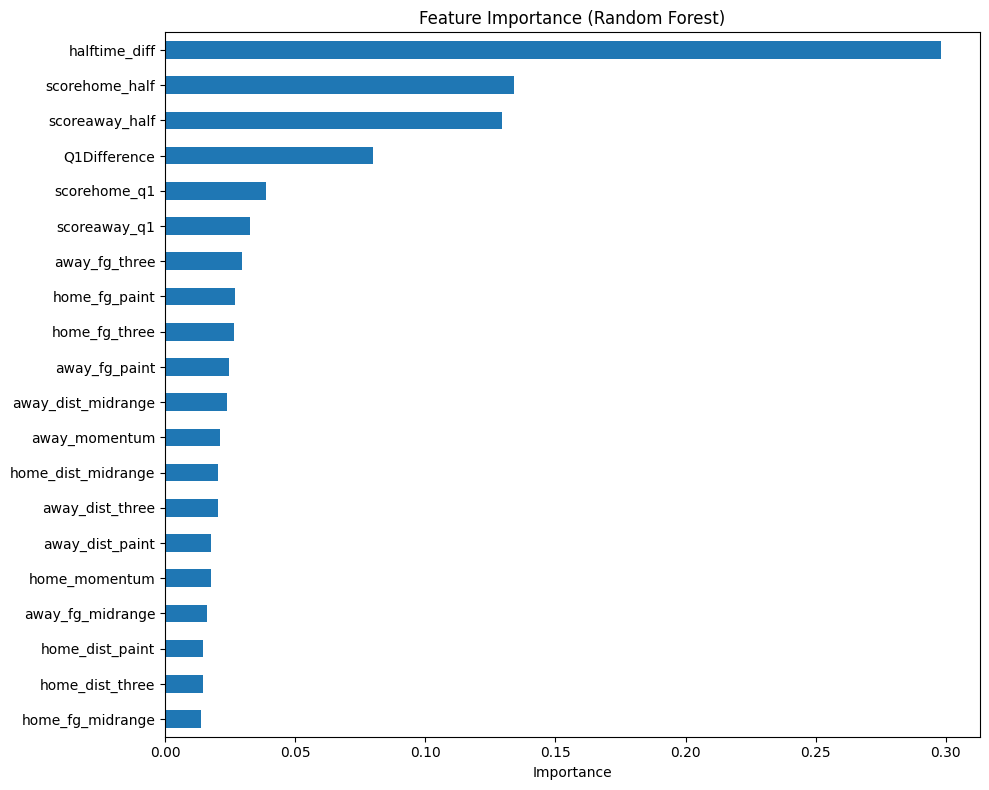

In [14]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

### Halftime Differential vs Win Probability

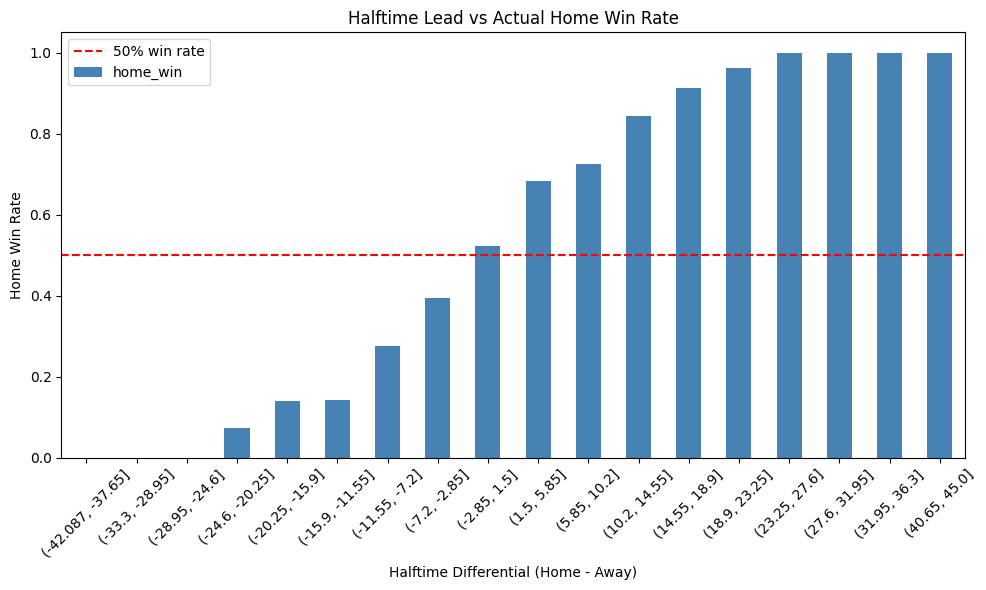

In [15]:
# Bin halftime differentials and calculate actual win rate per bin
final_df['diff_bin'] = pd.cut(final_df['halftime_diff'], bins=20)
win_rate = final_df.groupby('diff_bin', observed=True)['home_win'].mean()

plt.figure(figsize=(10, 6))
win_rate.plot(kind='bar', color='steelblue')
plt.axhline(y=0.5, color='red', linestyle='--', label='50% win rate')
plt.xlabel('Halftime Differential (Home - Away)')
plt.ylabel('Home Win Rate')
plt.title('Halftime Lead vs Actual Home Win Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary

| Model | Train Accuracy | Test Accuracy |
|-------|---------------|---------------|
| Logistic Regression | ~73% | ~73% |
| Random Forest (max_depth=5) | ~78% | ~73% |

**Key Findings:**
- Halftime score differential is the dominant predictor (34% importance)
- Raw halftime scores (home and away) are the next most important features
- Shot location features (FG% and distribution by zone) contribute 1-3% each
- Both models converge at ~73% test accuracy, suggesting this is roughly the ceiling for halftime-only prediction
- The halftime lead vs win rate chart shows a clear S-curve: teams up 15+ at halftime win ~90%+ of the time

## 8. Export Predictions to Postgres

Generate win probabilities for every game using the Random Forest model and write to a `halftime_predictions` table for Metabase dashboarding.

In [16]:
# Generate win probabilities for all games
predictions = pd.DataFrame({
    'gameid': X.index,
    'halftime_diff': X['halftime_diff'],
    'home_win_prob': rf_model.predict_proba(X)[:, 1],
    'predicted_win': rf_model.predict(X),
    'actual_win': y.values
})

# Write to Postgres
conn = psycopg2.connect(
    dbname=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    host=os.getenv('DB_HOST'),
    password=os.getenv('DB_PASSWORD'),
    port=os.getenv('DB_PORT')
)
cur = conn.cursor()

cur.execute("DROP TABLE IF EXISTS halftime_predictions")
cur.execute("""
    CREATE TABLE halftime_predictions (
        gameid VARCHAR(20) PRIMARY KEY,
        halftime_diff INTEGER,
        home_win_prob NUMERIC(4,3),
        predicted_win INTEGER,
        actual_win INTEGER
    )
""")

for _, row in predictions.iterrows():
    cur.execute(
        "INSERT INTO halftime_predictions VALUES (%s, %s, %s, %s, %s)",
        (row['gameid'], int(row['halftime_diff']), round(row['home_win_prob'], 3),
         int(row['predicted_win']), int(row['actual_win']))
    )

conn.commit()
cur.close()
conn.close()

print(f"Wrote {len(predictions)} predictions to halftime_predictions table")
predictions.head(10)

Wrote 1830 predictions to halftime_predictions table


,gameid,halftime_diff,home_win_prob,predicted_win,actual_win
gameid,,,,,
0022400001,0022400001,0,0.465010,0,0
0022400002,0022400002,6,0.707927,1,1
0022400003,0022400003,11,0.749672,1,1
0022400004,0022400004,-4,0.329975,0,0
0022400005,0022400005,11,0.777067,1,1
0022400006,0022400006,-15,0.099460,0,0
0022400007,0022400007,-4,0.475173,0,1
0022400008,0022400008,7,0.715776,1,1
0022400009,0022400009,-6,0.305754,0,0
